# Assignment: Capstone Project - The Battle of Neighborhoods (Week 2)

### Import required libraries

In [1]:
#!conda install -c conda-forge seaborn --yes

In [2]:
#import librairies used for the project
import numpy as np 
import pandas as pd 
import folium
import requests
from bs4 import BeautifulSoup
import os
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
print('All libraries are imported')

All libraries are imported


### Collect and Clean data regarding London streets longitude and latitude

In [3]:
res = requests.get("https://www.latlong.net/category/streets-235-17.html")
#res = requests.get("https://www.latlong.net/category/cities-235-15.html")
soup = BeautifulSoup(res.content, "html.parser")
table = soup.find("table")

In [4]:
regions=[]
longs=[]
lats=[]
list_eliminations = [', London, the UK', ', UK', ', London, UK', ', the UK', ', London']
for row in table.findAll("tr"):
    cells = row.findAll("td")
    if len(cells)==3: #Only extract table body not heading
        region = cells[0].find(text=True)
        #for elim in list_eliminations:
        #    region = region.replace(elim,'')
        regions.append(region)
        longs.append(cells[1].find(text=True))
        lats.append(cells[2].find(text=True))
df=pd.DataFrame(regions,columns=["street"])
df["longitude"]=longs
df["latitude"]=lats

convert_dict = {'longitude': float, 
                'latitude': float
               } 
  
df = df.astype(convert_dict)
#df.tocsv('uk_data.csv')
print(df.shape)
print(df.head())

(15, 3)
                                        street  longitude  latitude
0                Harley Street, London, the UK  51.520599 -0.147700
1                   Savile Row, London, the UK  51.511284 -0.140709
2  Antrim Coast Road, Northern Ireland, the UK  54.681999 -5.880000
3           Camden High Street, London, the UK  51.536388 -0.140556
4             Hyde Park Corner, London, the UK  51.502777 -0.151250


### Get London features and visualize the streets on a map

In [113]:
address = 'London, UK'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of UK are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of UK are 51.5073219, -0.1276474.


In [100]:
# create map of UK using latitude and longitude values
map_uk = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, region in zip(df['longitude'], df['latitude'], df['street']):
    label = region
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_uk)  
    
map_uk

### Specify the crendentials for Foursquare API

In [9]:
CLIENT_ID = '4GEA3GGCIKPQB05J5V5TZNP3PZR3NEM4MX555QBHJS5NYVNW' # your Foursquare ID
CLIENT_SECRET = '3I3WAX3N0M4XFIIUG5J1RWVIPPMCN4GZ4A4PWQGLMGW3TKDL' # your Foursquare Secret
VERSION = '20200310' # Foursquare API version

# defining radius and limit of venues to get
radius=500
LIMIT=100

### Get the venues of the streets in the dataset

In [10]:
streets = df['street'].tolist()
latitudes = df['latitude'].tolist()
longitudes = df['longitude'].tolist()
venues_list = []

for name, lat, lng in zip(streets, latitudes, longitudes):
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lng, 
        lat, 
        radius, 
        LIMIT)
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    if results:
        venues_list.append([( 
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['street', 
                      'latitude', 
                      'longitude', 
                      'venue', 
                      'venue latitude', 
                      'venue longitude', 
                      'venue category']
    else:
        print('No Results')
#nearby_venues.to_csv('gb_venues.csv')

No Results
No Results


#### Display the list of venues from the streets we have

In [11]:
nearby_venues

,street,latitude,longitude,venue,venue latitude,venue longitude,venue category
0,"Harley Street, London, the UK",-0.147700,51.520599,Royal Institute of British Architects,51.521108,-0.145014,Art Gallery
1,"Harley Street, London, the UK",-0.147700,51.520599,Daunt Books,51.520433,-0.151824,Bookstore
2,"Harley Street, London, the UK",-0.147700,51.520599,Pierre Marcolini Chocolatier,51.520653,-0.151909,Dessert Shop
3,"Harley Street, London, the UK",-0.147700,51.520599,La Fromagerie,51.519858,-0.152238,Cheese Shop
4,"Harley Street, London, the UK",-0.147700,51.520599,Jardin Du Jasmin,51.521534,-0.143434,Café
...,...,...,...,...,...,...,...
663,"Oxford Street, London, UK",-0.141099,51.515419,Waitrose & Partners JL Foodhall,51.515093,-0.145093,Supermarket
664,"Oxford Street, London, UK",-0.141099,51.515419,Disrepute,51.512121,-0.138179,Cocktail Bar
665,"Oxford Street, London, UK",-0.141099,51.515419,Beast,51.515356,-0.146896,Steakhouse
666,"Oxford Street, London, UK",-0.141099,51.515419,Fresh Healthy Eating Cafe,51.513228,-0.136394,Juice Bar


#### Then, the venues found by Foursquare API are analyzed such as the number of unique venues and unique venues' categories. We present some charts of the venues' distribution.

Number of unique categories is: 156
Number of unique venues is: 533


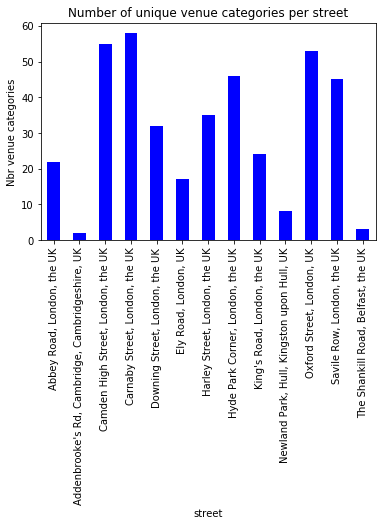

In [12]:
print('Number of unique categories is:', len(nearby_venues['venue category'].unique()))
print('Number of unique venues is:', len(nearby_venues['venue'].unique()))
categories = nearby_venues.groupby("street")["venue category"].apply(lambda x: len(list(np.unique(x))))
categories.plot.bar(color="blue")
plt.title('Number of unique venue categories per street')
plt.xlabel('street')
plt.ylabel('Nbr venue categories')
plt.show()

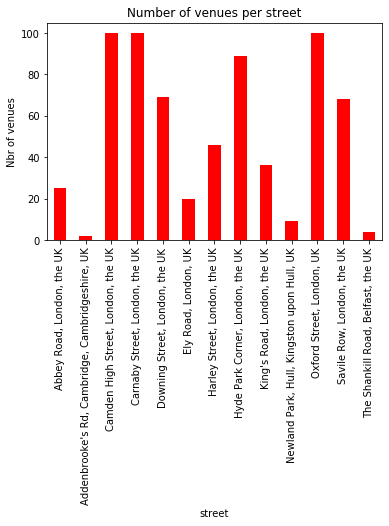

In [13]:
categories = nearby_venues.groupby("street")["venue"].count()
categories.plot.bar(color="red")
plt.title('Number of venues per street')
plt.xlabel('street')
plt.ylabel('Nbr of venues')
plt.show()

#### The maximum number of unique categories per venue is 58 and the minimum is 1.


### Get the unique categories for the streets in the dataset.
#### The top-5 categories are: Hotel, Coffee Shop, Clothing Store, Pub and French Restaurant.

In [14]:
df_str_cat = nearby_venues.groupby("venue category")["street"].count().to_frame()
df_str_cat.columns = ["nb_streets"]
df_str_cat = df_str_cat.reset_index()
df_str_cat.sort_values(by='nb_streets', ascending=False)

,venue category,nb_streets
72,Hotel,33
27,Coffee Shop,30
116,Pub,26
25,Clothing Store,26
54,French Restaurant,17
...,...,...
117,Radio Station,1
118,Ramen Restaurant,1
77,Indie Theater,1
120,Recording Studio,1


### Create the new dataframe and display the top 3 venues for each neighborhood

In [15]:
# Analyze each of the streets from the results
# one hot encoding
london_onehot = pd.get_dummies(nearby_venues[['venue category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['street'] = nearby_venues['street'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,street,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bar,...,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Harley Street, London, the UK",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Harley Street, London, the UK",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Harley Street, London, the UK",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Harley Street, London, the UK",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Harley Street, London, the UK",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
london_grouped = london_onehot.groupby('street').mean().reset_index()
london_grouped

,street,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bar,...,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Abbey Road, London, the UK",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.04,0.040000,0.000000,...,0.00,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04
1,"Addenbrooke's Rd, Cambridge, Cambridgeshire, UK",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Camden High Street, London, the UK",0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.00,0.010000,0.040000,...,0.00,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,"Carnaby Street, London, the UK",0.000000,0.00,0.040000,0.010000,0.010000,0.000000,0.00,0.010000,0.000000,...,0.00,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.030000,0.00
4,"Downing Street, London, the UK",0.000000,0.00,0.028986,0.000000,0.000000,0.000000,0.00,0.014493,0.014493,...,0.00,0.014493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Ely Road, London, UK",0.000000,0.00,0.000000,0.000000,0.000000,0.050000,0.00,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,"Harley Street, London, the UK",0.000000,0.00,0.021739,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.00,0.000000,0.021739,0.000000,0.021739,0.000000,0.043478,0.000000,0.000000,0.00
7,"Hyde Park Corner, London, the UK",0.011236,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.011236,...,0.00,0.000000,0.011236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
8,"King's Road, London, the UK",0.027778,0.00,0.027778,0.000000,0.000000,0.000000,0.00,0.111111,0.000000,...,0.00,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.027778,0.00
9,"Newland Park, Hull, Kingston upon Hull, UK",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.111111,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


In [17]:
# method to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
# get the top venues per street
london_grouped = london_onehot.groupby('street').mean().reset_index()
num_top_venues = 3
indicators = ['st', 'nd', 'rd']

columns = ['street']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
london_venues_sorted = pd.DataFrame(columns=columns)
london_venues_sorted['street'] = london_grouped['street']

for ind in np.arange(london_grouped.shape[0]):
    london_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

london_venues_sorted.head(20)

,street,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"Abbey Road, London, the UK",Cricket Ground,Coffee Shop,Yoga Studio
1,"Addenbrooke's Rd, Cambridge, Cambridgeshire, UK",Playground,Campground,Yoga Studio
2,"Camden High Street, London, the UK",Coffee Shop,Pub,Greek Restaurant
3,"Carnaby Street, London, the UK",Clothing Store,Boutique,Coffee Shop
4,"Downing Street, London, the UK",Pub,Hotel,Monument / Landmark
5,"Ely Road, London, UK",Supermarket,Coffee Shop,Pub
6,"Harley Street, London, the UK",French Restaurant,Hotel,Indian Restaurant
7,"Hyde Park Corner, London, the UK",Hotel,Lounge,Italian Restaurant
8,"King's Road, London, the UK",Bakery,Pub,English Restaurant
9,"Newland Park, Hull, Kingston upon Hull, UK",Coffee Shop,Library,Bookstore


#### Visualize the data regardin the top-3 venues for each street to have an insight which street to choose for opening the Coffee Shop

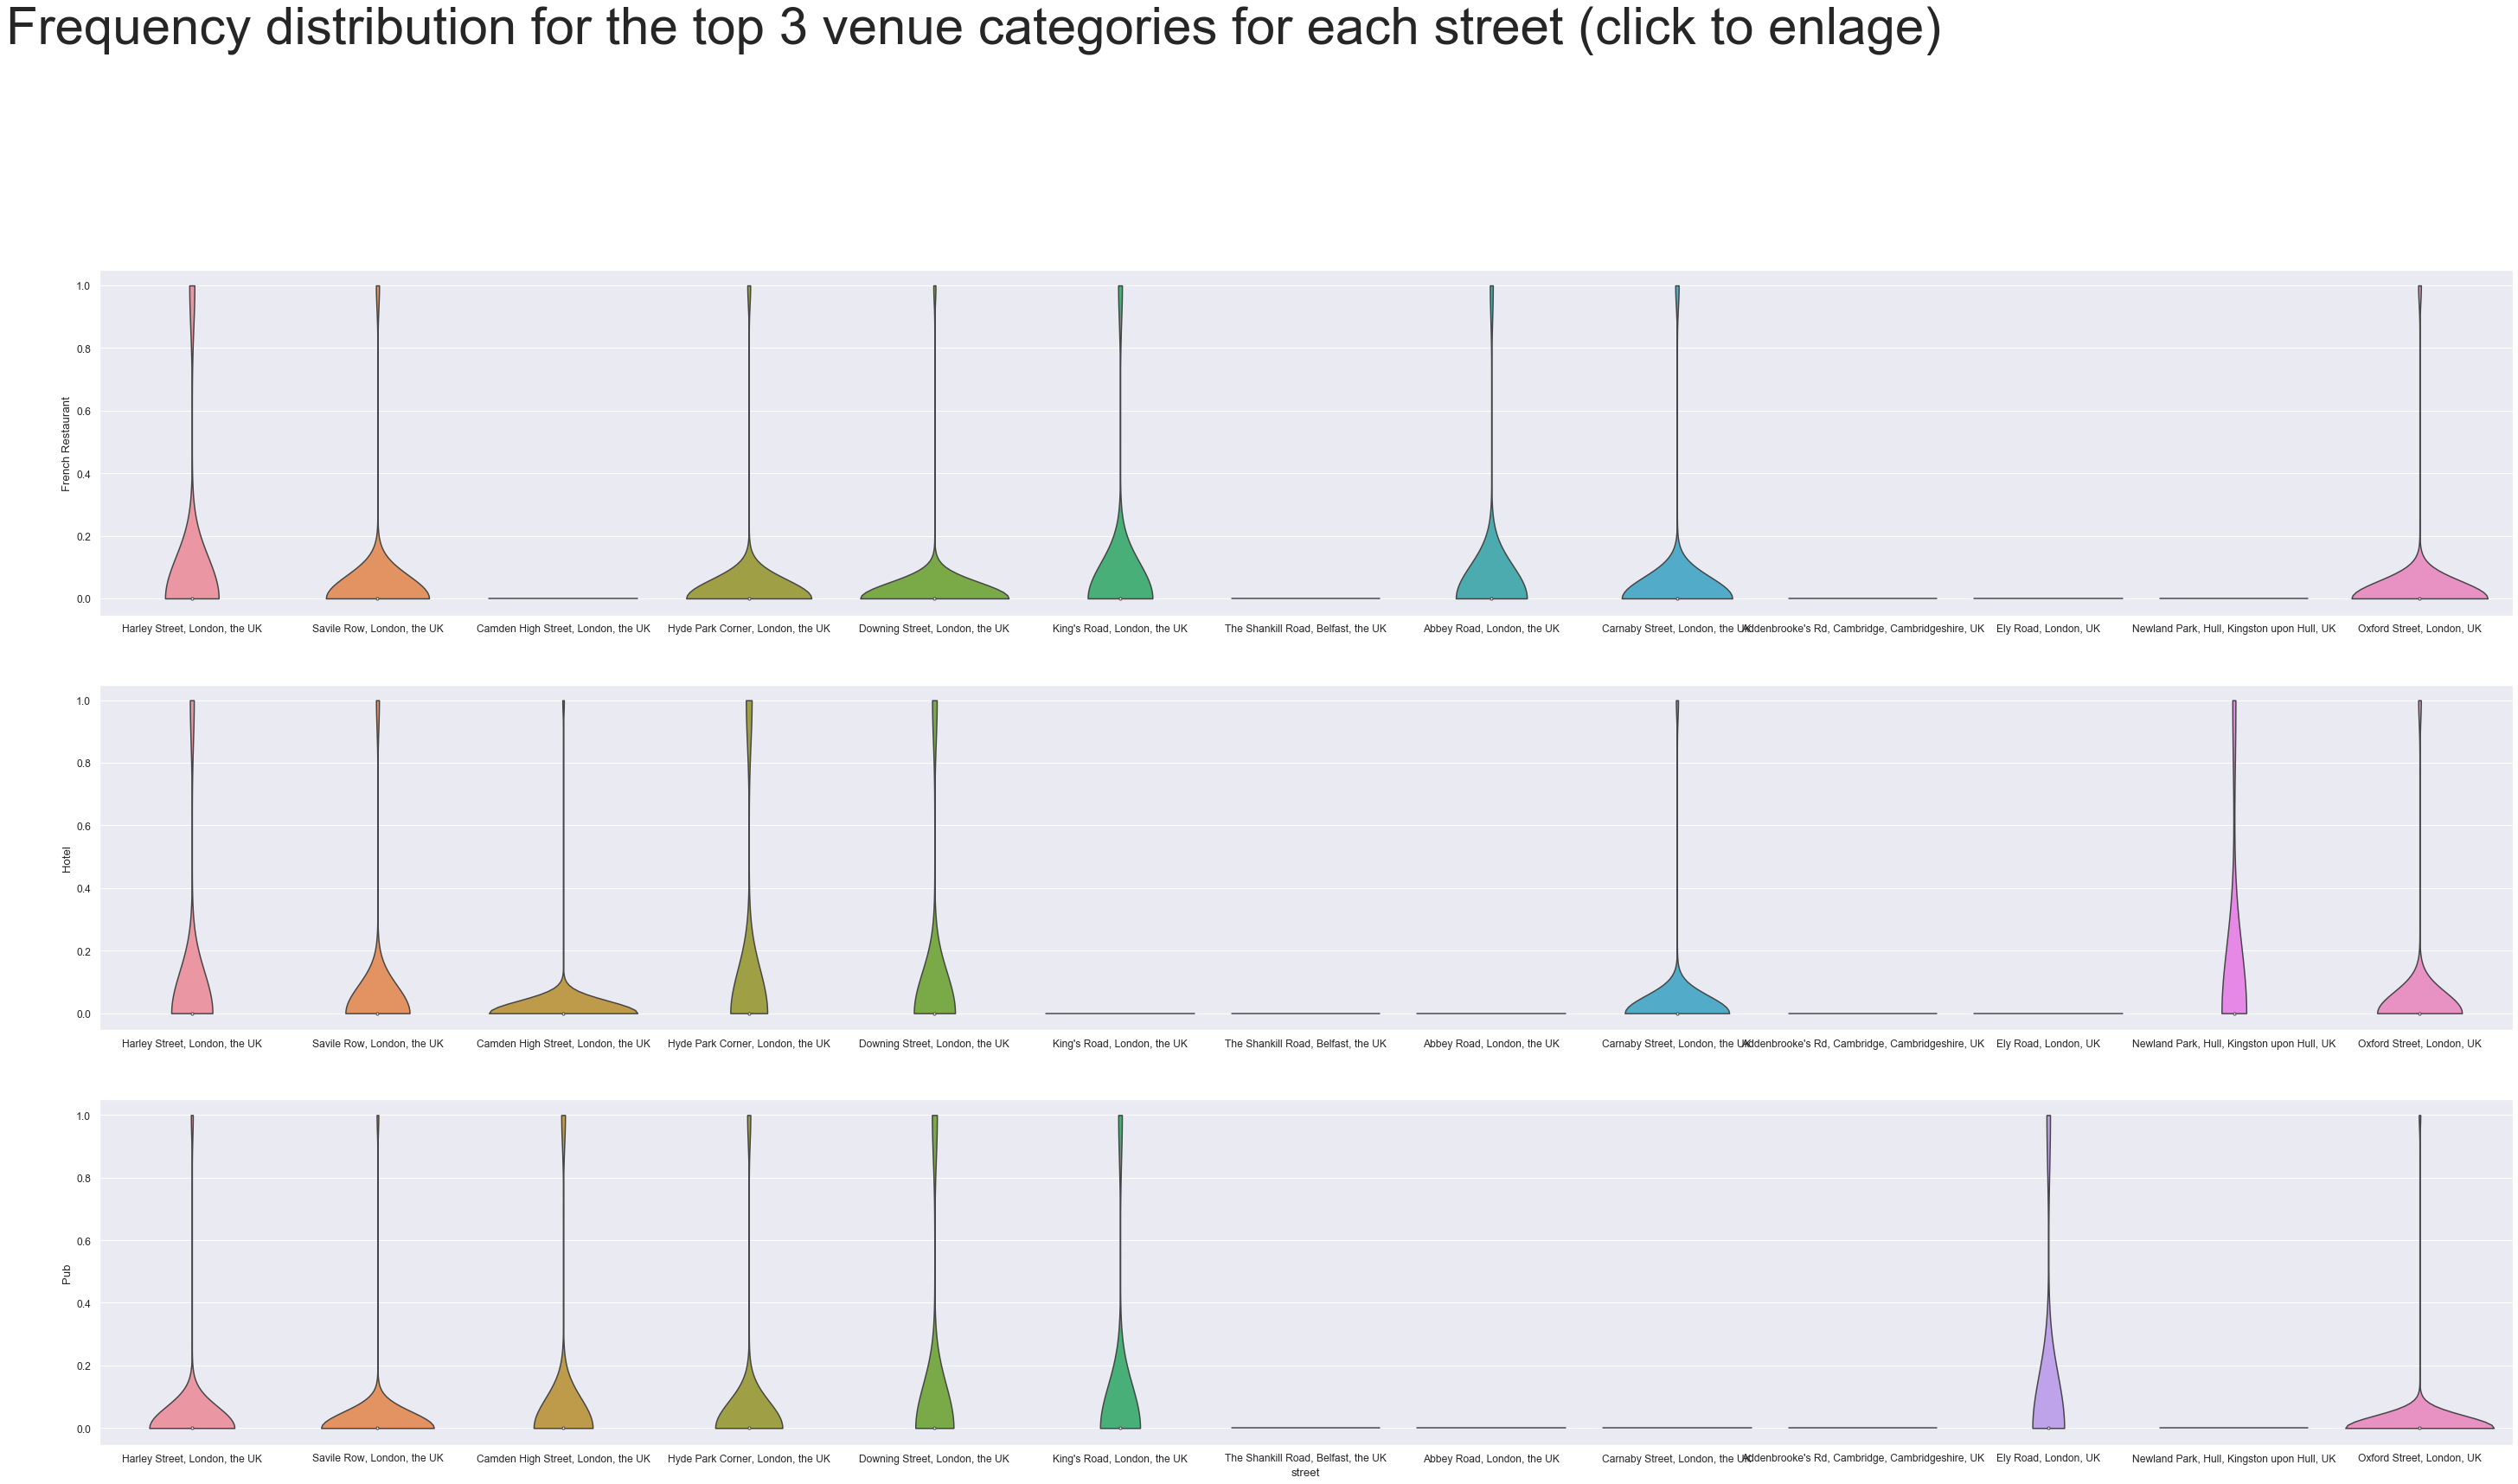

In [19]:
import seaborn as sns

fig = plt.figure(figsize=(50,25))
sns.set(font_scale=1.1)

ax = plt.subplot(3,1,1)
sns.violinplot(x="street", y="French Restaurant", data=london_onehot, cut=0);
plt.xlabel("")

ax = plt.subplot(3,1,2)
sns.violinplot(x="street", y="Hotel", data=london_onehot, cut=0);
plt.xlabel("")

plt.subplot(3,1,3)
sns.violinplot(x="street", y="Pub", data=london_onehot, cut=0);

ax.text(-1.0, 3.1, 'Frequency distribution for the top 3 venue categories for each street (click to enlage)', fontsize=60)
plt.savefig ("Distribution_Frequency_Venues_3_categories.png", dpi=240)
plt.show()



### Explore the category " Coffee Shop"
#### Check the frequency of Coffee Shop in each street to get an overview as the data may give some insights on the location.

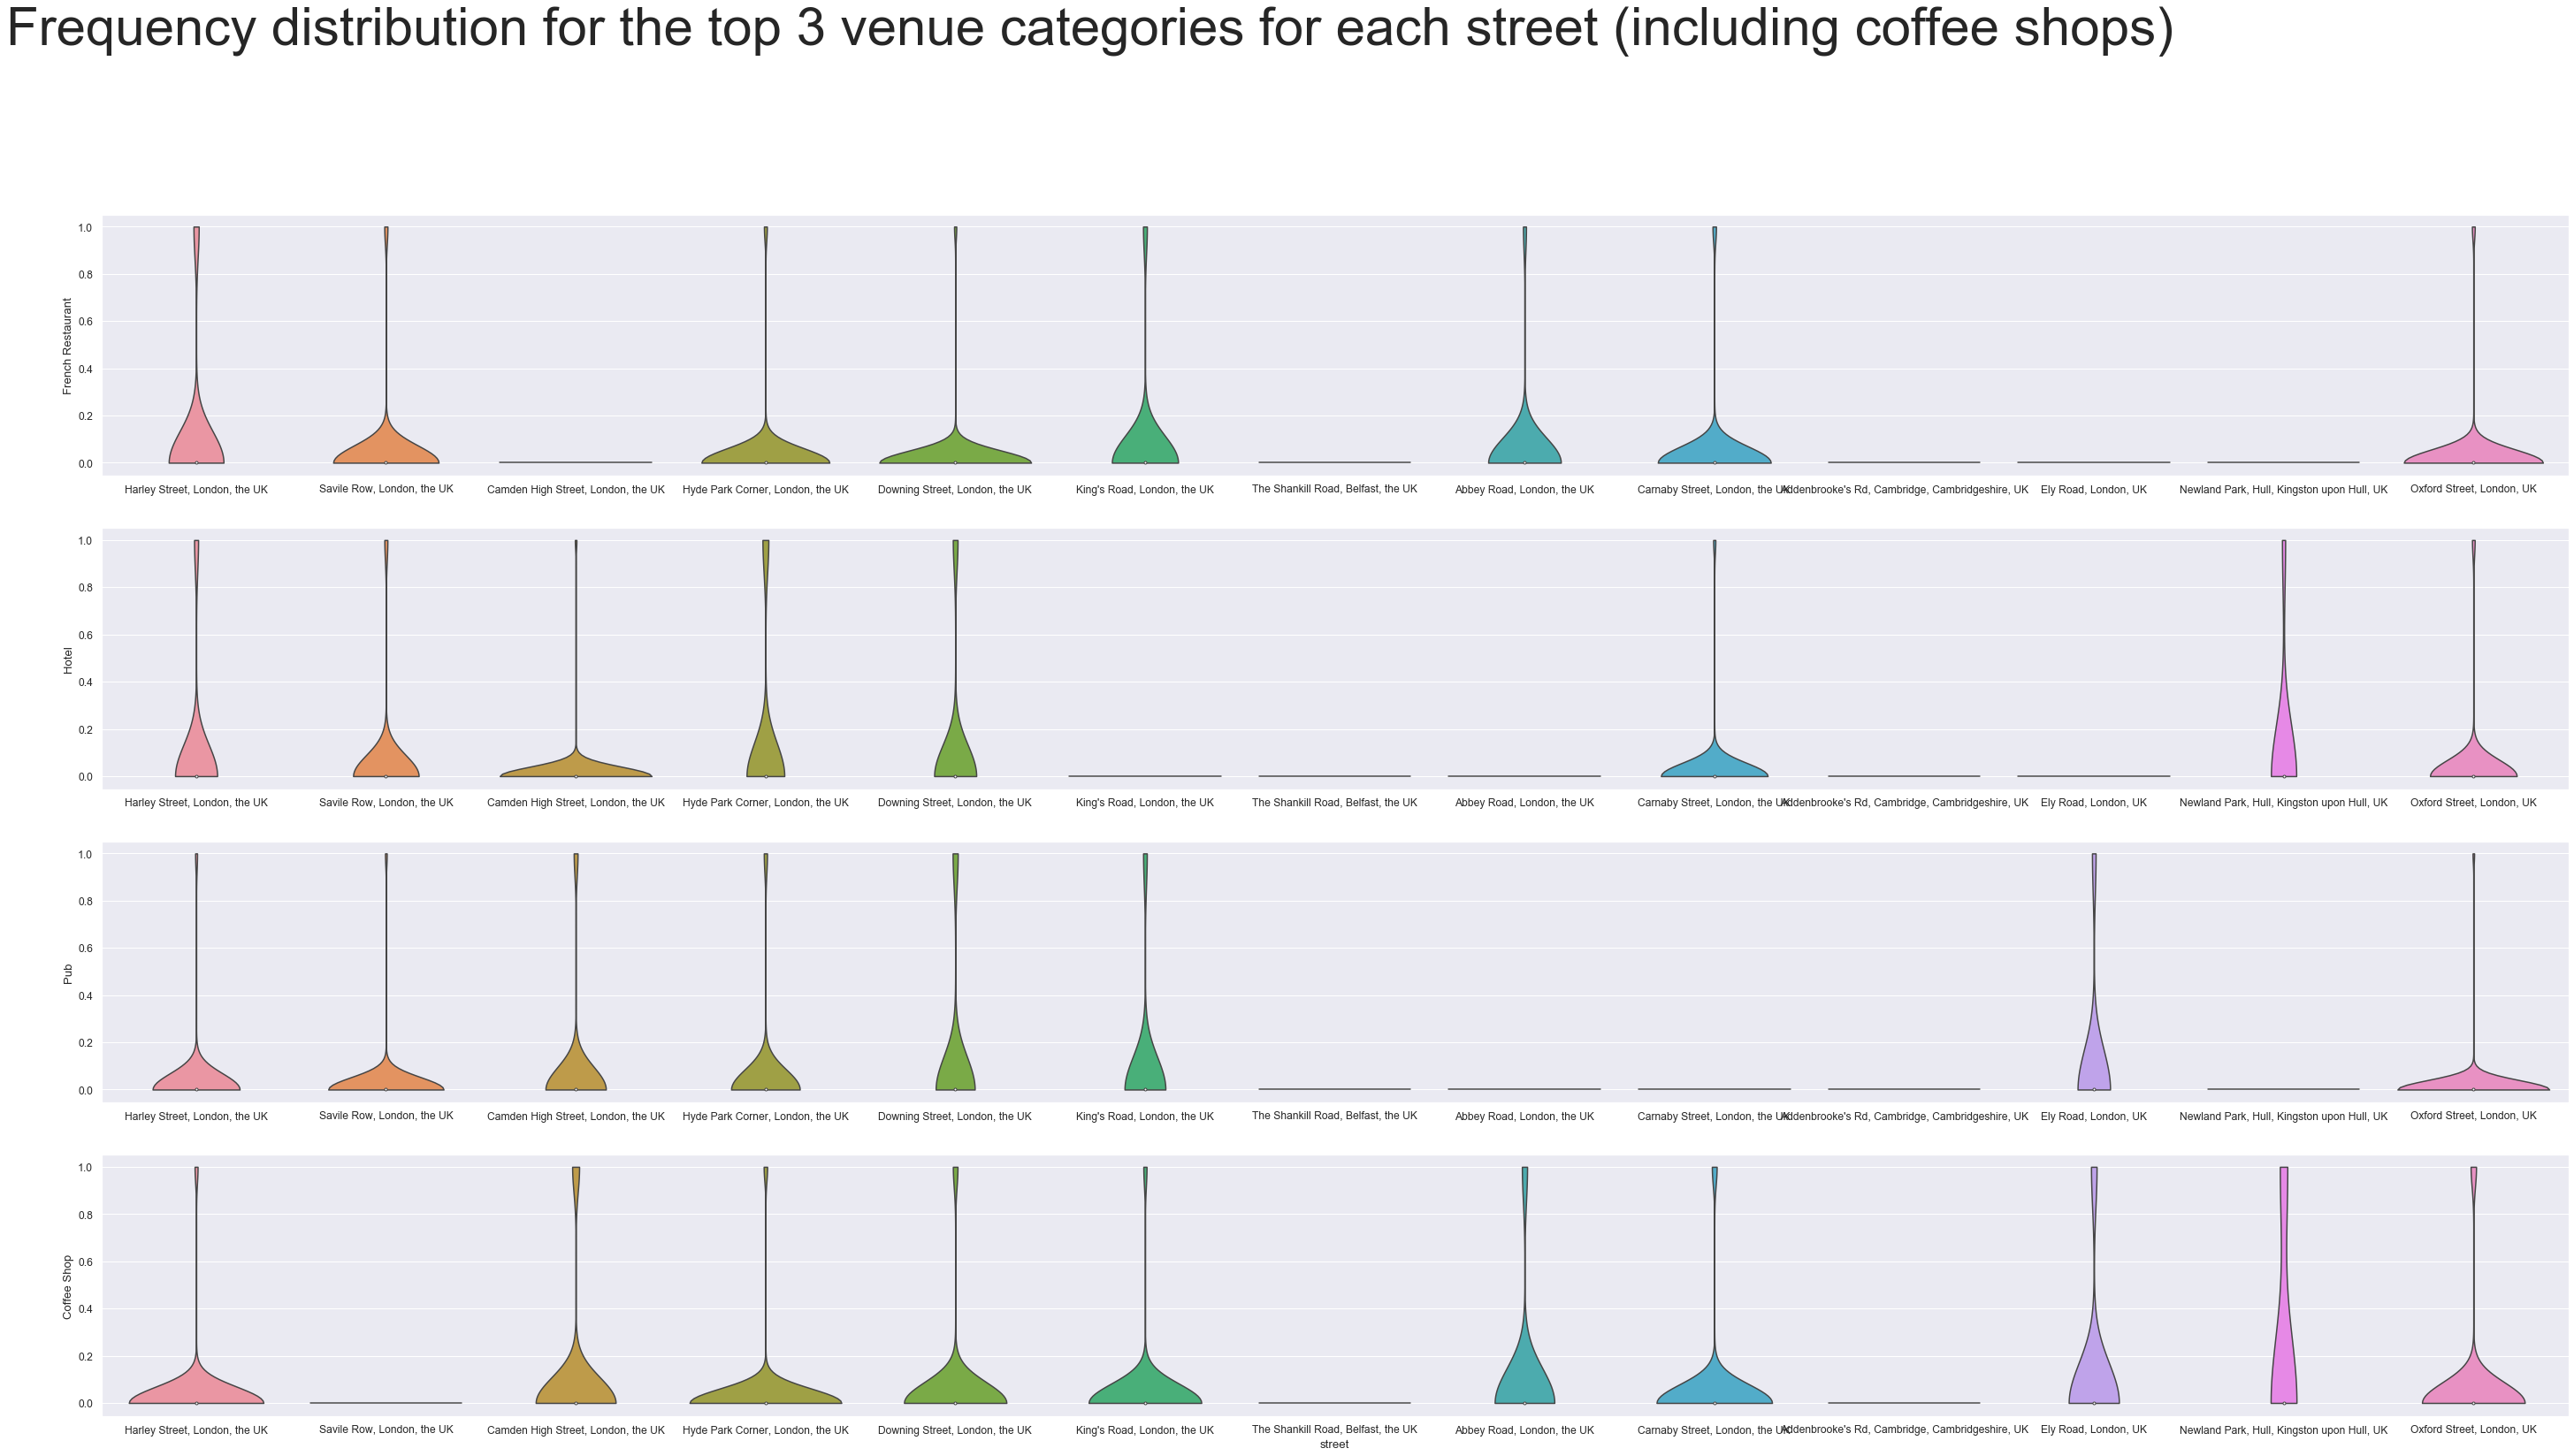

In [20]:
import seaborn as sns

fig = plt.figure(figsize=(50,25))
sns.set(font_scale=1.1)

ax = plt.subplot(4,1,1)
sns.violinplot(x="street", y="French Restaurant", data=london_onehot, cut=0);
plt.xlabel("")

ax = plt.subplot(4,1,2)
sns.violinplot(x="street", y="Hotel", data=london_onehot, cut=0);
plt.xlabel("")

plt.subplot(4,1,3)
sns.violinplot(x="street", y="Pub", data=london_onehot, cut=0);
plt.xlabel("")

plt.subplot(4,1,4)
sns.violinplot(x="street", y="Coffee Shop", data=london_onehot, cut=0);


ax.text(-1.0, 3.1, 'Frequency distribution for the top 3 venue categories for each street (including coffee shops)', fontsize=60)
plt.savefig ("Distribution_Frequency_Venues_3_categories_coffee.png", dpi=240)
plt.show()


#### From the displayed data, we chose 3 streets based on the criteria the clients gave. Thus, the final selection contains the following 3 streets:
- Harley Street
- Hyde Park Corner
- Oxford street

### Get the selected streets and visualize them on a map

In [23]:
selected_streets = df[df["street"].isin(['Hyde Park Corner, London, the UK',
                                         'Harley Street, London, the UK',
                                         'Oxford Street, London, UK'])]
selected_streets

,street,longitude,latitude
0,"Harley Street, London, the UK",51.520599,-0.147700
4,"Hyde Park Corner, London, the UK",51.502777,-0.151250
14,"Oxford Street, London, UK",51.515419,-0.141099


In [24]:
# Create a map of London with the 3 selected streets
map_selected_streets = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(selected_streets['latitude'], selected_streets['longitude'],
                           selected_streets['street']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lng, lat],
        radius=45,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_selected_streets)  
    
map_selected_streets


### Cluster the streets based on the number of coffee shops, pubs, hotels, and French restaurants.

In [101]:
# Get the Coffee shops number for each street
streets_coffee = london_grouped[['street', 'Coffee Shop']]
streets_coffee_gr = streets_coffee.groupby('street').sum().reset_index()
streets_coffee_gr

,street,Coffee Shop
0,"Abbey Road, London, the UK",0.080000
1,"Addenbrooke's Rd, Cambridge, Cambridgeshire, UK",0.000000
2,"Camden High Street, London, the UK",0.080000
3,"Carnaby Street, London, the UK",0.040000
4,"Downing Street, London, the UK",0.043478
5,"Ely Road, London, UK",0.100000
6,"Harley Street, London, the UK",0.021739
7,"Hyde Park Corner, London, the UK",0.022472
8,"King's Road, London, the UK",0.027778
9,"Newland Park, Hull, Kingston upon Hull, UK",0.222222


In [102]:
# Get the hotels number for each street
streets_hotels = london_grouped[['street', 'Hotel']]
streets_hotels_gr = streets_hotels.groupby('street').sum().reset_index()
streets_hotels_gr

,street,Hotel
0,"Abbey Road, London, the UK",0.000000
1,"Addenbrooke's Rd, Cambridge, Cambridgeshire, UK",0.000000
2,"Camden High Street, London, the UK",0.010000
3,"Carnaby Street, London, the UK",0.020000
4,"Downing Street, London, the UK",0.101449
5,"Ely Road, London, UK",0.000000
6,"Harley Street, London, the UK",0.086957
7,"Hyde Park Corner, London, the UK",0.134831
8,"King's Road, London, the UK",0.000000
9,"Newland Park, Hull, Kingston upon Hull, UK",0.111111


In [104]:
# Get the french restaurants number for each street
streets_fr = london_grouped[['street', 'French Restaurant']]
streets_fr_gr = streets_fr.groupby('street').sum().reset_index()
streets_fr_gr

,street,French Restaurant
0,"Abbey Road, London, the UK",0.040000
1,"Addenbrooke's Rd, Cambridge, Cambridgeshire, UK",0.000000
2,"Camden High Street, London, the UK",0.000000
3,"Carnaby Street, London, the UK",0.030000
4,"Downing Street, London, the UK",0.014493
5,"Ely Road, London, UK",0.000000
6,"Harley Street, London, the UK",0.086957
7,"Hyde Park Corner, London, the UK",0.022472
8,"King's Road, London, the UK",0.055556
9,"Newland Park, Hull, Kingston upon Hull, UK",0.000000


In [105]:
streets_pub = london_grouped[['street', 'Pub']]
streets_pub_gr = streets_pub.groupby('street').sum().reset_index()
streets_pub_gr

,street,Pub
0,"Abbey Road, London, the UK",0.000000
1,"Addenbrooke's Rd, Cambridge, Cambridgeshire, UK",0.000000
2,"Camden High Street, London, the UK",0.060000
3,"Carnaby Street, London, the UK",0.000000
4,"Downing Street, London, the UK",0.115942
5,"Ely Road, London, UK",0.100000
6,"Harley Street, London, the UK",0.021739
7,"Hyde Park Corner, London, the UK",0.044944
8,"King's Road, London, the UK",0.083333
9,"Newland Park, Hull, Kingston upon Hull, UK",0.000000


In [106]:
# merge all dataframe to get insights about the features that will be used for clustering
pub_hotels =  pd.merge(streets_pub_gr, streets_hotels_gr, on="street") 
coffees_fr = pd.merge(streets_fr_gr, streets_coffee_gr, on="street")
df_gr = pd.merge(pub_hotels, coffees_fr, on="street")
df_gr.columns = ['street', 'Nbr Pub', 'Nbr Hotel', 'Nbr French Restaurant', 'Nbr Coffee Shop']

In [107]:
# merge with df to get the streets latitude and longitude
df_gr = pd.merge(df, df_gr, on="street")
df_gr

,street,longitude,latitude,Nbr Pub,Nbr Hotel,Nbr French Restaurant,Nbr Coffee Shop
0,"Harley Street, London, the UK",51.520599,-0.147700,0.021739,0.086957,0.086957,0.021739
1,"Savile Row, London, the UK",51.511284,-0.140709,0.014706,0.044118,0.029412,0.000000
2,"Camden High Street, London, the UK",51.536388,-0.140556,0.060000,0.010000,0.000000,0.080000
3,"Hyde Park Corner, London, the UK",51.502777,-0.151250,0.044944,0.134831,0.022472,0.022472
4,"Downing Street, London, the UK",51.503223,-0.127500,0.115942,0.101449,0.014493,0.043478
5,"King's Road, London, the UK",51.487370,-0.168874,0.083333,0.000000,0.055556,0.027778
6,"The Shankill Road, Belfast, the UK",54.604301,-5.953000,0.000000,0.000000,0.000000,0.000000
7,"Abbey Road, London, the UK",51.532005,-0.177331,0.000000,0.000000,0.040000,0.080000
8,"Carnaby Street, London, the UK",51.513332,-0.138889,0.000000,0.020000,0.030000,0.040000
9,"Addenbrooke's Rd, Cambridge, Cambridgeshire, UK",52.166824,0.125377,0.000000,0.000000,0.000000,0.000000


#### Now, we will perform the clustering to get different streets clusters based on the criteria defined. Thus, we first remove the streets names. Then, we apply Elbow method to define which number of clusters is best suitable to answer our business problem.

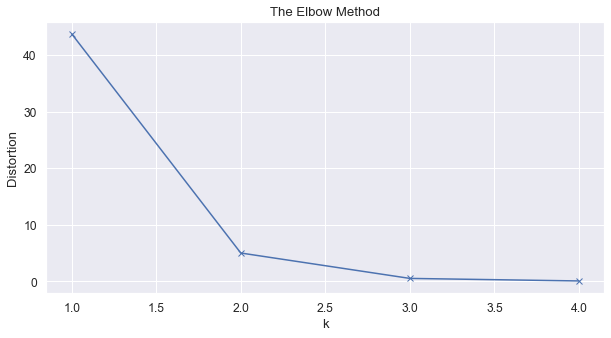

In [108]:
df_clust = df_gr.drop(['street'], axis=1)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

distortions = []

K = range(1,5)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(df_clust)
    distortions.append(kmean.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

#### From the Elbow Method, the k chosen for clustering is 2.

In [112]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_gr['street'].astype(str))
df_gr['street'] = le.transform(df_gr['street'].astype(str))
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_gr)
df_gr['cluster'] = kmeans.labels_
df_gr

,street,longitude,latitude,Nbr Pub,Nbr Hotel,Nbr French Restaurant,Nbr Coffee Shop,cluster
0,9,51.520599,-0.147700,0.021739,0.086957,0.086957,0.021739,0
1,3,51.511284,-0.140709,0.014706,0.044118,0.029412,0.000000,1
2,5,51.536388,-0.140556,0.060000,0.010000,0.000000,0.080000,1
3,10,51.502777,-0.151250,0.044944,0.134831,0.022472,0.022472,0
4,7,51.503223,-0.127500,0.115942,0.101449,0.014493,0.043478,0
5,11,51.487370,-0.168874,0.083333,0.000000,0.055556,0.027778,0
6,4,54.604301,-5.953000,0.000000,0.000000,0.000000,0.000000,1
7,0,51.532005,-0.177331,0.000000,0.000000,0.040000,0.080000,1
8,6,51.513332,-0.138889,0.000000,0.020000,0.030000,0.040000,0
9,1,52.166824,0.125377,0.000000,0.000000,0.000000,0.000000,1


#### Accoring to the business criteria, the best locations are in _Cluster 0_ where the locations in _Cluster 1_ do not fit the criteria of having all pubs, hotels, french restaurants.
#### Consequently, the final choice will be among the following streets:

In [110]:
df_results = df_gr[df_gr['cluster'] == 0]
df_results = pd.merge(df_results, df, on="longitude")
df_results

,street_x,longitude,latitude_x,Nbr Pub,Nbr Hotel,Nbr French Restaurant,Nbr Coffee Shop,cluster,street_y,latitude_y
0,6,51.520599,-0.147700,0.021739,0.086957,0.086957,0.021739,0,"Harley Street, London, the UK",-0.147700
1,2,51.536388,-0.140556,0.060000,0.010000,0.000000,0.080000,0,"Camden High Street, London, the UK",-0.140556
2,4,51.503223,-0.127500,0.115942,0.101449,0.014493,0.043478,0,"Downing Street, London, the UK",-0.127500
3,0,51.532005,-0.177331,0.000000,0.000000,0.040000,0.080000,0,"Abbey Road, London, the UK",-0.177331
4,3,51.513332,-0.138889,0.000000,0.020000,0.030000,0.040000,0,"Carnaby Street, London, the UK",-0.138889
5,1,52.166824,0.125377,0.000000,0.000000,0.000000,0.000000,0,"Addenbrooke's Rd, Cambridge, Cambridgeshire, UK",0.125377
6,5,51.573174,-0.007290,0.100000,0.000000,0.000000,0.100000,0,"Ely Road, London, UK",-0.007290


#### As the client has specific criteria, we need to select venues according to them. Thus, the streets where there are no hotels nor French restaurants will be eliminated from the selection.

In [111]:
df_results = df_results[df_results['Nbr French Restaurant'] != 0]
df_results = df_results[df_results['Nbr Hotel'] != 0]
df_results

,street_x,longitude,latitude_x,Nbr Pub,Nbr Hotel,Nbr French Restaurant,Nbr Coffee Shop,cluster,street_y,latitude_y
0,6,51.520599,-0.147700,0.021739,0.086957,0.086957,0.021739,0,"Harley Street, London, the UK",-0.147700
2,4,51.503223,-0.127500,0.115942,0.101449,0.014493,0.043478,0,"Downing Street, London, the UK",-0.127500
4,3,51.513332,-0.138889,0.000000,0.020000,0.030000,0.040000,0,"Carnaby Street, London, the UK",-0.138889


### Conclusion
These results support our choice of two out of the three streets sleected preivously based only on first analysis of the data without clustering. Consequently, the final choice included the two streets: Hyde Park Corner and Harley Street.

Another thing that should be taking into consideration is the presence or not of coffee shops around the streets selected.

Based on that, the selection is narrowed to the **Harley Street** where only one coffee shop is present and there are the most important number of French Restaurants, or **Hyde Park Corner** where there are only 2 coffee shops and 2 French restaurants but 12 hotels and 4 pubs.